## Imports

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from model_classes import HealthModel
import torch

## Config

Linear regressor config:

In [26]:
config = {
    "architecture": "linear_regressor",
    "train_size": 0.8,
    "val_size": False, # Set MLP 
    "hidden_layer_sizes": False, # configs
    "batch_size": False, # to False
    "num_epochs": False, # if using
    "learning_rate": False, # linear regressor
    "species": "NO2",
    "spatial_resolution": "regional",
    "temporal_resolution": "daily",
    "input_artifacts": ["laqn-regional", "met-resample", "income-regional"],
    "met_variables": ["temperature"] # Set to False if excluding meteorology
    }

plot_title_model = "(all inputs)"

MLP regressor config:

In [58]:
config = {
    "architecture": "MLP_regressor",
    "train_size": 0.7,
    "val_size": 0.15, # Set MLP configs
    "hidden_layer_sizes": [10],
    "batch_size": 30, # to False
    "num_epochs": 100, # if using
    "learning_rate": 0.001, # linear regressor
    "species": "NO2",
    "spatial_resolution": "regional",
    "temporal_resolution": "daily",
    "input_artifacts": ["laqn-regional", "met-resample", "income-regional"],
    "met_variables": ["temperature"] # Set to False if excluding meteorology
    }

plot_title_model = "(excluding income)"
torch.manual_seed(1)

## Code

In [59]:
model = HealthModel(config)

In [60]:
model.preprocess_and_log()

In [61]:
model.train_and_log()

100%|██████████| 100/100 [00:28<00:00,  3.46it/s]


training_loss,0.17287
validation_loss,0.28137
r2_train,-0.14796
r2_val,-5.23123
mean_squared_error_train,0.23009
mean_squared_error_val,0.31885
mean_absolute_percentage_error_train,18.24037
mean_absolute_percentage_error_val,34.59432
_runtime,44
_timestamp,1622217573
_step,99


training_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
r2_train,▁▇██████████████████████████████████████
r2_val,▁██████████████████████▇██▇██▇███▇████▇▇
mean_squared_error_train,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error_val,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▂▁▁▁▂▁▁▁▁▂▂
mean_absolute_percentage_error_train,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_percentage_error_val,█▁▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [62]:
data_dict = model.test_and_log()

r2_test,-2.36467
mean_squared_error_test,0.17369
mean_absolute_percentage_error_test,20.09694
_runtime,15
_timestamp,1622217594
_step,0


r2_test,▁
mean_squared_error_test,▁
mean_absolute_percentage_error_test,▁
_runtime,▁
_timestamp,▁
_step,▁


In [63]:
df = pd.DataFrame()
if config["val_size"]:
    subsets = ["train", "validat", "test"]
else:
    subsets = ["train", "test"]
for subset in subsets:
    subset_df = pd.DataFrame(index=pd.DatetimeIndex(data_dict[f"{subset}_dates"]), data={"observed":data_dict[f"y_{subset}"], "predicted":data_dict[f"y_{subset}_predict"]})
    if df.empty:
        df = subset_df.copy()
    else:
        df = df.append(subset_df)

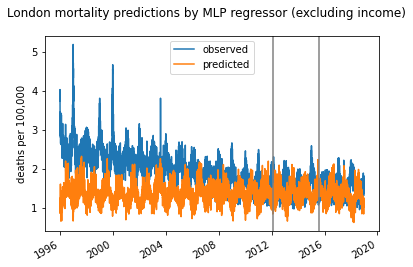

<Figure size 2160x1080 with 0 Axes>

In [64]:
df.plot()
plt.axvline(data_dict["train_dates"].max(), color="grey")
if config["val_size"]:
    plt.axvline(data_dict["validat_dates"].max(), color="grey")
plt.legend()
plt.ylabel("deaths per 100,000")
model_title = config["architecture"].replace("_", " ")
plt.suptitle(f"London mortality predictions by {model_title} {plot_title_model}")
plt.figure(figsize=(30,15))
plt.show()